In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from saif.crs_model.peakdetector import pk_indxs
plt.style.use('ggplot')


### Load Data

In [5]:
SEISMIC_DATA = '../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingSeismic.hdf5'
PRESSURE_DATA = '../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingPressure.hdf5'

In [6]:
from orion_light import seismic_catalog
from orion_light import pressure_table

In [7]:
catalog = seismic_catalog.SeismicCatalog()
catalog.load_catalog_hdf5(SEISMIC_DATA)

In [8]:
pressure_model = pressure_table.PressureTableModel()
pressure_model.load_table(PRESSURE_DATA)

Loading pressure table from hdf5 file: ../../../dataset_preparing/datasets_Jul_7/cushing_oklahoma/cushingPressure.hdf5


### Process $N(t)$

- Pressure data and seismic events are recorded at different times.
    - First goal: Clip all data to the time interval where we have samples for both pressure and seismic activity
    - Second goal: linearly interpolate the seismic data so that the event times align with the pressure data.
    - Third goal: empirically compute the rate (numerical derivative), in order to define R0.
- Partition the data into **main shock** and **interseismic** regions.
    - This should be done by a peak detector, but right now it is done manually (by visual inspection).

In [9]:
from scipy.interpolate import interp1d

Obtain the time intervals for the seismic data, and creating the interpolator.

In [10]:
Mc = 1.6
catalog.set_slice(magnitude_range = [Mc, 10])
event_times = catalog.get_epoch_slice() 
start_t = event_times[0]
end_t = event_times[-1]
event_times = event_times / 86400 / 365.25

t_n = event_times - event_times[0]
n_cnts = np.arange(len(t_n))
n_func = interp1d(t_n, n_cnts, kind='linear')

Obtain the time intervals for the pressure data, and interpolate the seismic data

In [11]:
t_p = pressure_epoch = pressure_model.table_data['t']
start_idx = np.where(t_p > start_t)[0][0]
end_idx = np.where(t_p > end_t)[0][0] - 1

t_p = t_p[start_idx:end_idx]
p = pressure_model.table_data['pressure'][1:][start_idx+1:end_idx]
dpdt = pressure_model.table_data['dpdt'][1:][start_idx+1:end_idx]

delta_t = t_p[1:] - t_p[:-1]

p = torch.FloatTensor(p)
dpdt = torch.FloatTensor(dpdt)
delta_t = torch.FloatTensor(delta_t)

t_p_interpolated = t_p / 86400 / 365.25 - event_times[0]
n_interpolated = n_func(t_p_interpolated) # interpolated number of earthquakes 

[   0 1087 1550 1972 2192 2521 3163 3668]
8


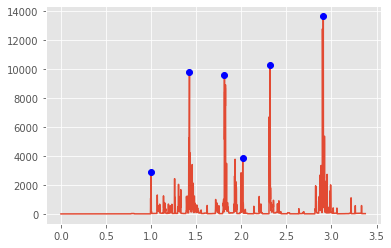

In [34]:
empirical_rate = np.gradient(n_interpolated, t_p_interpolated)
peak_indexs=pk_indxs(empirical_rate,trshd=0.2, min_dist=100)
plt.plot(t_p_interpolated, empirical_rate)
plt.plot(t_p_interpolated[peak_indexs],empirical_rate[peak_indexs],'o',color='b')
peak_indexs=np.insert(peak_indexs,0,0)
peak_indexs=np.insert(peak_indexs,np.size(peak_indexs),np.size(t_p_interpolated)-1)
print(peak_indexs)
print(np.size(peak_indexs))

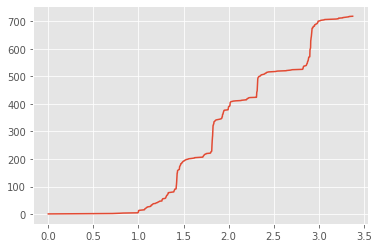

In [14]:
plt.plot(t_p_interpolated, n_interpolated)

Examining the first interseismic chunk (from t=0 years to t=1.3 years)

In [15]:
train_end = np.where(t_p_interpolated > 1.3)[0][0]

### Define site constants

### Sampling the grid

We keep the rate factor fixed, and examine the landscape for mu_minus_alpha and rate_coeff.

In [16]:
params = torch.FloatTensor([[0.5,1e-2,1e-4]])


# mu_minus_alpha_mesh = torch.linspace(0.1,1.0,101)
# rate_coeff_mesh = 10 ** torch.linspace(-4,-1,101)
# grid_mu, grid_rate = torch.meshgrid(mu_minus_alpha_mesh, rate_coeff_mesh, indexing='ij')

# params = torch.stack([
#     grid_mu.flatten(),
#     grid_rate.flatten(),
#     163.7424 / 1e6 * torch.ones_like(grid_rate.flatten()), # rate_factor 
# ]).T

# params.requires_grad_()



### Run Model

In [20]:
mpa_yr2pa_s = 1e6 / 365.25 / 86400
site_info = {
    'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
    'tectonic_normal_stressing_rate' : 0, # Pa/s
    'sigma' : 30 * 1e6, # Pa
    'biot' : 0.3, # dimensionless
    #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
    'background_rate' : empirical_rate[0] / 365.25 / 86400, # event/second,
    'init_delta_t' : delta_t[0].item() }
from model import CRSModel
model = CRSModel(site_info)

In [21]:
Rt, Nt = model(params, p, dpdt, delta_t)

In [22]:
Rt

tensor([[4.9332e-08, 4.9340e-08, 4.9347e-08,  ..., 2.9382e-06, 2.9384e-06,
         2.9387e-06]])

In [23]:
Nt.shape

torch.Size([1, 3669])

Visualize a sample

Define the criterion: MSELoss.

- Be careful: we may need to normalize the data before using MSELoss.
- In future, we might forecast rate (or, $\Delta N(t)$) since this is easier to bound than total number.

In [39]:
#criterion = nn.MSELoss(reduction='sum')

In [40]:
#loss = criterion(Nt[:,1:], n_target[None,:])
#loss.item()

In [41]:
#loss.backward()

In [24]:
mpa_yr2pa_s = 1e6 / 365.25 / 86400
site_info = {
    'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
    'tectonic_normal_stressing_rate' : 0, # Pa/s
    'sigma' : 30 * 1e6, # Pa
    'biot' : 0.3, # dimensionless
    #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
    'background_rate' : empirical_rate[0] / 365.25 / 86400, # event/second,
    'init_delta_t' : delta_t[0].item() }

In [48]:
from model import CRSModel
import torch.optim as optim
import torch.nn.functional as F
model = CRSModel(site_info)

# params = torch.FloatTensor([[0.5,1e-2,0.0005]])
params = torch.FloatTensor([[5.0000e-01, 9.9910e-03, 5.1348e-05]])
params.requires_grad=True
params.register_hook(lambda g: F.normalize(g))



criterion = nn.MSELoss(reduction='sum')
R0, N0 , n_target0 = torch.ones(1, 1),torch.ones(1, 1),torch.FloatTensor([])
for i in range(np.size(peak_indexs)-1):
   mpa_yr2pa_s = 1e6 / 365.25 / 86400
   site_info = {
    'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
    'tectonic_normal_stressing_rate' : 0, # Pa/s
    'sigma' : 30 * 1e6, # Pa
    'biot' : 0.3, # dimensionless
    #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
    'background_rate' : empirical_rate[peak_indexs[i]+1] / 365.25 / 86400, # event/second,
    'init_delta_t' : delta_t[0].item() }
   model = CRSModel(site_info)
   p0 = torch.FloatTensor(p)[peak_indexs[i]+1:peak_indexs[i+1]]
   dpdt0 = torch.FloatTensor(dpdt)[peak_indexs[i]+1:peak_indexs[i+1]]
   delta_t0 = torch.FloatTensor(delta_t)[peak_indexs[i]+1:peak_indexs[i+1]]
   Rt, Nt = model(params, p0, dpdt0, delta_t0)
   R0=torch.cat((R0,Rt),dim=-1)
   #print(N0.detach()[0][-1])
   Nt=torch.add(Nt,N0.detach()[0][-1])
   #print(N0.detach())
   N0=torch.cat((N0,Nt),dim=-1)
   n_target= torch.FloatTensor(n_interpolated)[peak_indexs[i]:peak_indexs[i+1]]
   n_target0=torch.cat((n_target0,n_target),dim=-1)


In [51]:
optimizer = optim.SGD(params=[params],lr=0.00001,momentum=0.1)
for epoch in range(500):
    R0, N0 , n_target0 = torch.ones(1, 1),torch.ones(1, 1),torch.FloatTensor([])
    for i in range(np.size(peak_indexs)-1):
             mpa_yr2pa_s = 1e6 / 365.25 / 86400
             site_info = {
                          'tectonic_shear_stressing_rate' : 3.5e-4 * mpa_yr2pa_s, # Pa / s
                          'tectonic_normal_stressing_rate' : 0, # Pa/s
                          'sigma' : 30 * 1e6, # Pa
                          'biot' : 0.3, # dimensionless
                          #'background_rate' : 1.36 / 365.25 / 86400, # event/second,
                          'background_rate' : empirical_rate[peak_indexs[i]+1] / 365.25 / 86400, # event/second,
                          'init_delta_t' : delta_t[0].item() }
             model = CRSModel(site_info)
             p0 = torch.FloatTensor(p)[peak_indexs[i]+1:peak_indexs[i+1]]
             dpdt0 = torch.FloatTensor(dpdt)[peak_indexs[i]+1:peak_indexs[i+1]]
             delta_t0 = torch.FloatTensor(delta_t)[peak_indexs[i]+1:peak_indexs[i+1]]
             
             Rt, Nt = model(params, p0, dpdt0, delta_t0)
             #print(empirical_rate[peak_indexs[i]],)
             R0=torch.cat((R0,Rt),dim=-1)
             #print(N0.detach()[0][-1])
             Nt=torch.add(Nt,N0.detach()[0][-1])
             #print(N0.detach())
             N0=torch.cat((N0,Nt),dim=-1)
             n_target= torch.FloatTensor(n_interpolated)[peak_indexs[i]:peak_indexs[i+1]]
             n_target0=torch.cat((n_target0,n_target),dim=-1)
             #print(n_target0.detach().size(),(N0[:,1:]).squeeze().detach().size())
             

    # loss = criterion(Nt[:,1:], n_target[None,:]) # Need to define a loss function that compares with the real data
    # Define a MSE of forecasted number Nt with the ground truth
    
    
    #print((N0[:,1:]).squeeze().detach().numpy(),n_target0.detach().numpy())
    loss = criterion((N0[:,1:]).squeeze(), n_target0)
    if loss < 4000000:
        optimizer = optim.SGD(params=[params],lr=0.0000001,momentum=0.1)
    print('loss is ' + str(loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    Nt.shape

loss is 38912156.0
loss is 15520982.0
loss is 3570884.75
loss is 3523078.0
loss is 3476327.5
loss is 3430619.0
loss is 3385962.0
loss is 3342353.5
loss is 3299785.0
loss is 3258262.25
loss is 3217794.0
loss is 3178353.0
loss is 3139968.5
loss is 3102615.25
loss is 3066310.75
loss is 3031040.75
loss is 2996809.0
loss is 2963615.5
loss is 2931454.5
loss is 2900330.75
loss is 2870239.5
loss is 2841180.5
loss is 2813155.0
loss is 2786161.25
loss is 2760189.75
loss is 2786161.0
loss is 2760193.0
loss is 2786161.0
loss is 2760193.75
loss is 2786163.75
loss is 2760193.25
loss is 2786161.0
loss is 2760193.0
loss is 2786163.25
loss is 2760194.5
loss is 2786163.25
loss is 2760194.0
loss is 2786163.25
loss is 2760193.25
loss is 2786163.25
loss is 2760193.0
loss is 2786165.0


KeyboardInterrupt: 

tensor([[5.0000e-01, 9.9910e-03, 5.1348e-05]], requires_grad=True)


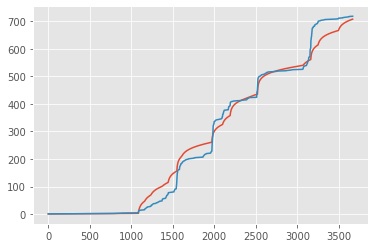

In [46]:
# Using Han's output
plt.plot((N0[:,1:]).squeeze().detach().numpy())
plt.plot(n_target0)
print(params)

tensor([[5.0000e-01, 9.9911e-03, 7.4635e-05]], requires_grad=True)


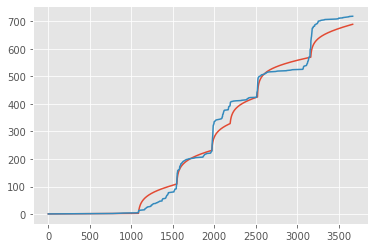

In [52]:
plt.plot((N0[:,1:]).squeeze().detach().numpy())
plt.plot(n_target0)
print(params)

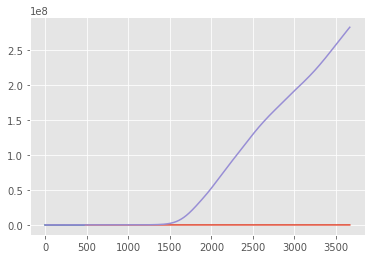

In [41]:
params = torch.FloatTensor([[5.0009e-01,2.7316e-03,3.0530e-04,5.0000e-04]])
Rt, Nt = model(params, p, dpdt, delta_t)
plt.plot(Nt.data.detach().numpy()[0])
plt.plot(n_target)
params = torch.FloatTensor([[5.0009e-01,2.7316e-03,163.7424,5.0000e-04]])
Rt, Nt = model(params, p, dpdt, delta_t)
plt.plot(Nt.data.detach().numpy()[0])

In [ ]:
print(Rt,Nt)